In [1]:
! pip install matplotlib opencv-python imutils pyfmm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import time
import cv2
import math
import random
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
from utils import *

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """A node class for RRT algorithm"""
        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:

        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])


    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area_x,
                 rand_area_y,
                 expand_dis=20.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500,
                 play_area=None
                 ):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randAreax:Random Sampling Area for x [min,max]
        randAreay:Random Sampling Area for y [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand_x = rand_area_x[0]
        self.max_rand_x = rand_area_x[1]
        self.min_rand_y = rand_area_y[0]
        self.max_rand_y = rand_area_y[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """
        self.node_list = [self.start]
        if animation:
            f, ax = plt.subplots()
        
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(new_node, self.play_area) and \
               self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node, ax, f)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    if animation:
                        self.draw_path(self.generate_final_course(len(self.node_list) - 1), ax, f)
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node, ax, f)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand_x, self.max_rand_x),
                random.uniform(self.min_rand_y, self.max_rand_y))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_path(self, path, ax, f):
        clear_output(wait=True)
        _xlist = []
        _ylist = []
        for [px, py] in path:
            _xlist.append(px)
            _ylist.append(py)
        for (ox, oy) in self.obstacle_list:
            ax.plot(ox, oy, "s", color='black', markersize=2)
        ax.plot(_xlist, _ylist, "-", color='r')
        ax.axis("equal")
        ax.axis([0, self.max_rand_x, 0, self.max_rand_y])
        ax.invert_yaxis()
        ax.grid(True)
        display(f)

    def draw_graph(self, rnd, ax, f):
        ax.cla()
        clear_output(wait=True)
        ax.axis("equal")
        ax.axis([0, self.max_rand_x, 0, self.max_rand_y])
        ax.invert_yaxis()
        if rnd is not None:
            ax.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                ax.plot(node.path_x, node.path_y, "-g")
        if self.play_area is not None:
            ax.plot([self.play_area.xmin, self.play_area.xmax,
                      self.play_area.xmax, self.play_area.xmin,
                      self.play_area.xmin],
                     [self.play_area.ymin, self.play_area.ymin,
                      self.play_area.ymax, self.play_area.ymax,
                      self.play_area.ymin],
                     "-k")
        ax.plot(self.start.x, self.start.y, "xr")
        ax.plot(self.end.x, self.end.y, "xr")
        ax.grid(True)
        display(f)
        plt.pause(0.001)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if node.x < play_area.xmin or node.x > play_area.xmax or \
           node.y < play_area.ymin or node.y > play_area.ymax:
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList):

        if node is None:
            return False

        for (ox, oy) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= 1**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

In [4]:
def rrt(maze, start, end, animation=False):
    x_w = len(maze[0])+1
    y_w = len(maze)+1
    obstacleList = maze2obs(maze, x_w, y_w)

    start_eq = (start[1],start[0])
    end_eq = (end[1],end[0])

    rrt_excute = RRT(start_eq, end_eq, rand_area_x=[0, x_w-1], rand_area_y=[0, y_w-1], obstacle_list=obstacleList)
    path = rrt_excute.planning(animation)

    if path is None:
        print("Cannot find path")

    return path

In [5]:
def pathplanning(start, end, image_path, animation=False, verbose=False):
    # Running Time Check
    starttime = time.time()

    # Convert map image to binary list
    img = cv2.imread(image_path)
    maze, DISTANCECOSTMAP = img2binList(img, lenWidth=100, GRID_SIZE=1, verbose=0) # for map.png, lenWidth=100, GRID_SIZE=1
    
    # Start and End point setting

    print("Start =", start, '\n', "End =", end)

    # Procedure Checking
    print(" ", "Path planning Proceeding...", " ")

    path = rrt(maze, start, end, animation)
    print("Path planning Succeed")
    print("time :", time.time() - starttime)

    if verbose:
        # Visualizing binary map and generated path
        showmaze = np.array(maze).astype(np.uint8)
        showmaze *= 255
        showmaze = np.stack((showmaze,)*3, axis=-1)
        num_of_searched_node = 0

        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                showmaze[start[0] - i][start[1] - j] = [0, 254, 0]
                showmaze[end[0] - i][end[1] - j] = [0, 0, 254]
        cv2.polylines(showmaze, [np.array(path, np.int32)], False, (200, 50, 200), 1)
        for point in path:
            _x = math.floor(point[0])
            _y = math.floor(point[1])
            cv2.circle(showmaze, (_x, _y), radius=0, color=(255,150,150), thickness=-1)
        showmaze = cv2.resize(showmaze, None, fx=5, fy=5, interpolation=cv2.INTER_NEAREST)

        img = cv2.cvtColor(showmaze, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(img))

    return path

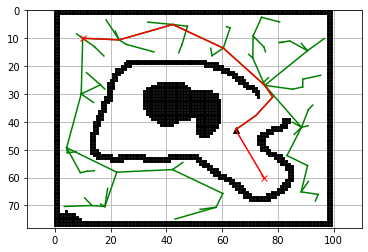

Path planning Succeed
time : 24.755435705184937


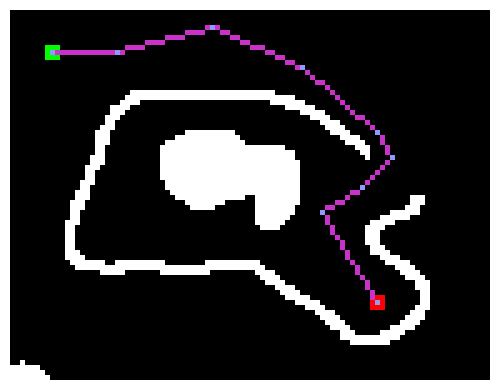

Path list: [[75, 60], [64.83034996343525, 42.83358019025848], [72.13135389927892, 37.712298252464116], [78.16186002911816, 31.1108058557346], [75.31239570166011, 26.893195901467045], [60.430178989264526, 13.5320722314574], [42.3072184645409, 5.072858212453433], [23.08051500042867, 10.580477834676161], [10, 10]]


In [6]:
start = (10, 10) # for map.png
end = (60, 75) # for map.png
path = pathplanning(start, end, image_path="map.png", animation=True, verbose=True)
print('Path list:', path)

the map will be created by the size: 100 X 78
Start = (10, 10) 
 End = (60, 75)
  Path planning Proceeding...  
Path planning Succeed
time : 1.6054775714874268


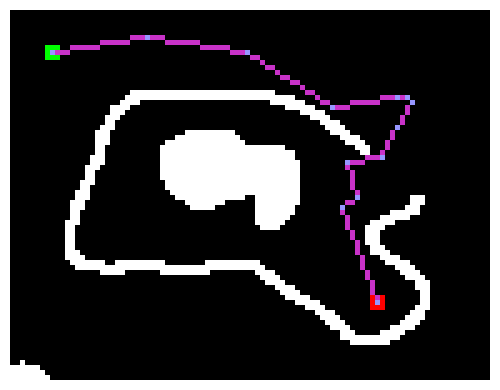

Path list: [[75, 60], [68.6873002476226, 41.46865510791812], [71.80609740938634, 39.335108812092955], [69.84567470994561, 32.923646679650105], [76.95770601300346, 31.530665881831244], [79.09219334082862, 25.908487286310617], [82.24462442810625, 20.67121537439992], [81.65662879302033, 19.86664030657033], [79.5430311756941, 19.67246083802843], [66.13713909553722, 21.95211924938807], [49.713957747372305, 10.538131584891275], [29.889121565574897, 7.896944282767464], [10, 10]]


In [7]:
path = pathplanning(start, end, image_path="map.png", animation=False, verbose=True)
print('Path list:', path)